In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Mathematical Explanation of Policy Gradient with Variance Reduction

## 1. Policy Gradient Theorem
The objective of the policy gradient algorithm is to maximize the expected return:
$$
J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^\infty \gamma^t r_{t+1} \right],
$$
where:
- $\theta$ are the parameters of the policy $\pi_\theta$,
- $\gamma \in [0, 1]$ is the discount factor,
- $r_{t+1}$ is the reward at time $t+1$,
- $\tau$ is a trajectory sampled from the policy.

Using the policy gradient theorem, the gradient of $J(\theta)$ is given by:
$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^\infty \nabla_\theta \log \pi_\theta(a_t | s_t) G_t \right],
$$
where $G_t$ represents the cumulative reward.

---

## 2. Variance Reduction Techniques

### a) Reward-to-Go
Instead of using the total reward of the trajectory $G_0^\infty$, reward-to-go reduces variance by using:
$$
G_t = \sum_{t'=t}^\infty \gamma^{t'-t} r_{t'+1},
$$
which is the discounted cumulative reward starting from time $t$. This reduces variance by focusing only on the future rewards influenced by the current action.

### b) Advantage Normalization
The advantage function compares the return of the current action to a baseline:
$$
A_t = G_t - b(s_t),
$$
where $b(s_t)$ is a baseline function. A common choice for $b(s_t)$ is the mean return across the batch.

To further stabilize training, the advantages are normalized:
$$
A_t^{\text{norm}} = \frac{A_t - \mu_A}{\sigma_A + \epsilon},
$$
where $\mu_A$ and $\sigma_A$ are the mean and standard deviation of $A_t$, and $\epsilon$ is a small constant to prevent division by zero.

---

## 3. Loss Function
The loss for policy optimization is defined as:
$$
L(\theta) = -\mathbb{E}_{\tau \sim \pi_\theta} \left[ \sum_{t=0}^\infty \log \pi_\theta(a_t | s_t) A_t \right].
$$
For implementation, we approximate this using Monte Carlo samples:
$$
L(\theta) \approx -\frac{1}{N} \sum_{i=1}^N \sum_{t=0}^\infty \log \pi_\theta(a_t | s_t) A_t,
$$
where $N$ is the batch size.

---

## 4. Training Process
1. Sample $N$ trajectories from the policy $\pi_\theta$.
2. Compute rewards $r_t$ for each trajectory.
3. Calculate $G_t$ using either:
   - Total trajectory reward: $G_0^\infty = \sum_{t=0}^\infty \gamma^t r_{t+1}$,
   - Reward-to-go: $G_t = \sum_{t'=t}^\infty \gamma^{t'-t} r_{t'+1}$.
4. Compute advantages $A_t$ as $G_t - b(s_t)$, and normalize if required.
5. Optimize the policy by minimizing the loss $L(\theta)$.

---

## 5. Testing and Evaluation
### Environments
- **CartPole-v0**: Reward of +1 for every time step the pole remains upright.
- **LunarLander-v2**: Reward based on proximity to the landing pad and fuel usage.

### Hyperparameters
- **Batch Size**: Affects variance in gradient estimates.
- **Iterations**: Total training updates.
- **Gamma**: Controls the trade-off between short-term and long-term rewards.

---

## 6. Learning Curve Comparison
- **Reward-to-Go**: Reduces variance by focusing on future rewards.
- **Advantage Normalization**: Centers and scales advantages for stable optimization.

Plotting average returns over iterations for different configurations helps visualize the impact of these techniques.


# About the Environments

## Cartpole-v0

In the Cartpole environment, a pole is attached by an unactuated joint to a cart, which moves along a frictionless track. The input to the system consists of:

- Cart position
- Cart velocity
- Pole angle
- Pole velocity at the tip

The system is controlled by applying a force that either pushes the cart to the left or right. The goal is to keep the pole upright by preventing it from falling over. A reward of +1 is provided for each time-step the pole remains upright. The episode ends when:

- The pole is more than 15 degrees from vertical
- The cart moves more than 2.4 units from the center

## Lunarlander-v2

The goal in the Lunar Lander environment is to land on the moon. The landing pad is always at coordinates (0,0). The state vector consists of:

- Coordinates of the lander
- Position and velocity

There are four discrete actions available:

1. Do nothing
2. Fire the left orientation engine
3. Fire the main engine
4. Fire the right orientation engine

The reward function is primarily determined by how close the lander is to the landing pad and how close it is to zero speed. The closer the lander is to landing, the higher the reward. Other factors include:

- Firing the main engine deducts points
- Moving away from the landing pad deducts points
- Crashing deducts points

The episode ends when the lander successfully lands, crashes, or flies off-screen.

---

# Tasks

## (a) Load the Gym Environments

- Load the Cartpole-v0 and Lunarlander-v2 environments from Gym.
- Print the state and action spaces.
- Develop a random agent to interact with the environment and understand the reward function.
- Record your observations.

## (b) Implement the Policy Gradient Algorithm

- Implement the policy gradient algorithm with and without the reward-to-go and advantage normalization functionality.
- For advantage normalization, use a suitable baseline function.
- Test the algorithm on Cartpole-v0 and Lunarlander-v2 environments.
- The code should be runnable from the command line with options for:
  - Environment name
  - Reward-to-go functionality (true/false)
  - Advantage normalization functionality (true/false)
  - Number of iterations
  - Batch size for the policy gradient
  - Other relevant command-line variables
- Attach comparison graphs of the learning curves (average return at each iteration) with and without advantage normalization and reward-to-go functionality.

## (c) Study the Impact of Batch Size

- Report the impact of varying batch sizes on policy gradient estimates for the Cartpole-v0 and Lunarlander-v2 environments.


In [4]:
import gym

def load_environment(env_name):
    try:
        env = gym.make(env_name)
        print(f"{ env_name }Loading ...")
        print(f"State space : {env.observation_space}")
        print(f"Action space: {env.action_space}")
        return env
    except gym.error.UnregisteredEnv:
        print(f"Error: The environment {env_name} is not found. Check the name of the environment.")
        return None
    except Exception as e:
        print(f"Error while loading the environment {str(e)}")
        return None

def random_agent(env, episodes = 5):
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            total_reward += reward
        print(f"Episode {episode+1} : Total reward = {total_reward} ")

if __name__ == "__main__":
    print("Loading CartPole-v0 Environment:")
    cartpole_env = load_environment("CartPole-v0")
    # print("\nLoading LunarLander-v2 Environment:")
    # lunarlander_env = load_environment("LunarLander-v2")

    print("\nRunning Random Agent on CartPole-v0:")
    random_agent(cartpole_env)

    # print("\nRunning Random Agent on LunarLander-v2:")
    # random_agent(lunarlander_env)



Loading CartPole-v0 Environment:
CartPole-v0Loading ...
State space : Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)

Running Random Agent on CartPole-v0:
Episode 1 : Total reward = 38.0 
Episode 2 : Total reward = 18.0 
Episode 3 : Total reward = 36.0 
Episode 4 : Total reward = 22.0 
Episode 5 : Total reward = 16.0 


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated,

# Key Features and Functionality Overview

## Command-line Arguments
| Argument           | Description                                     |
|--------------------|-------------------------------------------------|
| `--env`           | Specifies the environment name.                 |
| `--reward_to_go`  | Enables reward-to-go functionality.             |
| `--normalize_adv` | Enables advantage normalization.                |
| `--iterations`    | Sets the number of iterations.                  |
| `--batch_size`    | Defines the batch size for training.            |
| `--gamma`         | Specifies the discount factor.                  |
| `--lr`            | Sets the learning rate.                         |

## Functionality
1. **Return Computation**:
   - Calculates returns both with and without reward-to-go.

2. **Advantage Normalization**:
   - Normalizes advantages when `--normalize_adv` is enabled.

3. **Learning Curve Visualization**:
   - Displays the learning curve for comparing performance under different settings.

## Learning Curve Graph
The graph visualizes the **average return** at each iteration. Key features include:
- Labels for each curve, indicating the settings used.
- Clear axes for iterations (x-axis) and average returns (y-axis).

## Example Usage
```bash
python train.py --env CartPole-v0 --reward_to_go --normalize_adv --iterations 1000 --batch_size 500 --gamma 0.99 --lr 0.01


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import argparse

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim = 128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        state = torch.tensor(state, dtype=torch.float32) 
        x = torch.relu(self.fc1(state))
        return torch.softmax(self.fc2(x), dim = -1)

def normalize_advantages(advantages):
    advantages = np.array(advantages)
    return (advantages - advantages.mean()) / (advantages.std() + 1e-8)

def calculate_returns(rewards, gamma, reward_to_go):
    returns = []
    if reward_to_go:
        for t in range(len(rewards)):
            G = 0
            for k in range(t, len(rewards)):
                G += (gamma ** (k - t)) * rewards[k]
            returns.append(G)
    else:
        G = sum([(gamma ** t )* rewards[t] for t in range(len(rewards))])
        return [G] * len(rewards)

    return returns


def train_policy_gradient(env_name, reward_to_go = False, normalize_adv = False, iterations = 500, batch_size = 50, gamma = 0.99, lr = 0.01 ):
    env =load_environment(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Initialize policy network and optimizer
    policy = PolicyNetwork(state_dim, action_dim)
    optimizer = optim.Adam(policy.parameters(), lr)

    avg_returns = []

    for i in range(iterations):
        trajectories = []
        total_return = 0
        for _ in range(batch_size):
            states = []
            actions = []
            rewards = []
            log_probs = []
            done = False
            state = env.reset()

            while not done:
                # Predict action probabilities
                action_probs = policy(state).detach().numpy()
                action = np.random.choice(len(action_probs), p = action_probs)
                
                # Take action
                next_state, reward, done, _ = env.step(action)
                log_prob = torch.log(policy(state)[action])

                # Store predictions
                states.append(state)
                actions.append(action)
                rewards.append(reward)
                log_probs.append(log_prob)
                state = next_state

            returns = calculate_returns(rewards, gamma, reward_to_go)
            if normalize_adv:
                returns = normalize_advantages(returns)
                
            trajectories.append((log_probs, returns))
            total_return += sum(rewards)

        avg_returns.append(total_return / batch_size)
        # Update policy
        loss =0 
        for log_probs, returns in trajectories:
            for log_prob, G in zip(log_probs, returns):
                loss += -log_prob*G

        loss = loss/batch_size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Iteration {i + 1}/{iterations}, Loss: {loss.item()}, Avg_return: {total_return / batch_size}")

    env.close()

    # Plot learning curve
    plt.plot(avg_returns, label=f"Reward-to-Go: {reward_to_go}, Normalize: {normalize_adv}")
    plt.xlabel("Iterations")
    plt.ylabel("Average Return")
    plt.title(f"Policy Gradient on {env_name}")
    plt.legend()
    plt.show()


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser(description="Policy Gradient with Variance Reduction Techniques")
#     parser.add_argument("--env", type=str, default="CartPole-v0", help="Gym environment name")
#     parser.add_argument("--reward_to_go", type=bool, default=False, help="Use reward-to-go")
#     parser.add_argument("--normalize_adv", type=bool, default=False, help="Use advantage normalization")
#     parser.add_argument("--iterations", type=int, default=200, help="Number of training iterations")
#     parser.add_argument("--batch_size", type=int, default=50, help="Batch size")
#     parser.add_argument("--gamma", type=float, default=0.99, help="Discount factor")
#     parser.add_argument("--lr", type=float, default=0.01, help="Learning rate")

#     args = parser.parse_args()

#     train_policy_gradient(
#         env_name=args.env,
#         reward_to_go=args.reward_to_go,
#         normalize_adv=args.normalize_adv,
#         iterations=args.iterations,
#         batch_size=args.batch_size,
#         gamma=args.gamma,
#         lr=args.lr
#     )



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CartPole-v0Loading ...
State space : Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Iteration 10/200, Loss: -1.785095453262329
Iteration 20/200, Loss: 0.0018124580383300781
Iteration 30/200, Loss: -0.9596916437149048
Iteration 40/200, Loss: -0.0307058934122324
Iteration 50/200, Loss: -3.755842924118042
Iteration 60/200, Loss: 1.1814730167388916
Iteration 70/200, Loss: -0.24251499772071838
Iteration 80/200, Loss: 1.3020082712173462
Iteration 90/200, Loss: -1.1613372564315796
Iteration 100/200, Loss: 1.5810959339141846
Iteration 110/200, Loss: 1.0175151824951172
Iteration 120/200, Loss: 0.5193784832954407
Iteration 130/200, Loss: -0.713735818862915
Iteration 140/200, Loss: -0.7420326471328735
Iteration 150/200, Loss: 0.03118307888507843
Iteration 160/200, Loss: -0.8741084933280945
Iteration 170/200, Loss: -3.9641425609588623
Iteration 180/200, Loss: -3.1044979095458984


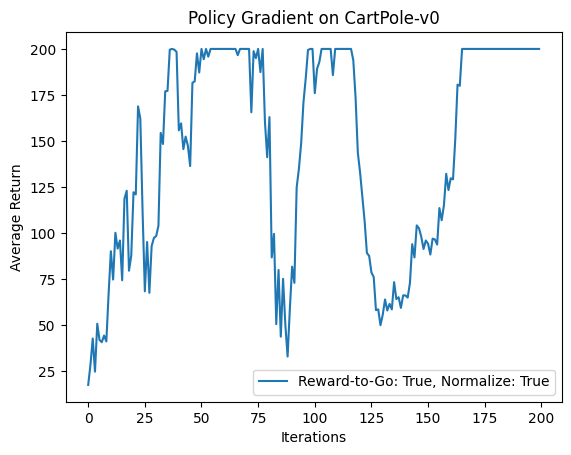

In [9]:
if __name__ == "__main__":
    train_policy_gradient(env_name="CartPole-v0", reward_to_go=True, normalize_adv=True, iterations=200, batch_size=5)        

CartPole-v0Loading ...
State space : Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Iteration 10/200, Loss: 2.262918087581056e-06
Iteration 20/200, Loss: -8.827806823319406e-07
Iteration 30/200, Loss: 2.3835796127968933e-06
Iteration 40/200, Loss: -2.0270094864827115e-06
Iteration 50/200, Loss: -1.3988130831421586e-06
Iteration 60/200, Loss: -1.0156215921597322e-06
Iteration 70/200, Loss: 4.921068921248661e-07
Iteration 80/200, Loss: 6.3610445977246854e-06
Iteration 90/200, Loss: 2.41936913880636e-06
Iteration 100/200, Loss: 5.601646257957782e-09
Iteration 110/200, Loss: -1.563209252708475e-06
Iteration 120/200, Loss: -8.764120025261946e-07
Iteration 130/200, Loss: 2.26975043915445e-06
Iteration 140/200, Loss: 2.7921757919102674e-06
Iteration 150/200, Loss: 4.210267434245907e-06
Iteration 160/200, Loss: -6.746080316588632e-07
Iteration 170/200, Loss: 7.33847613787475e

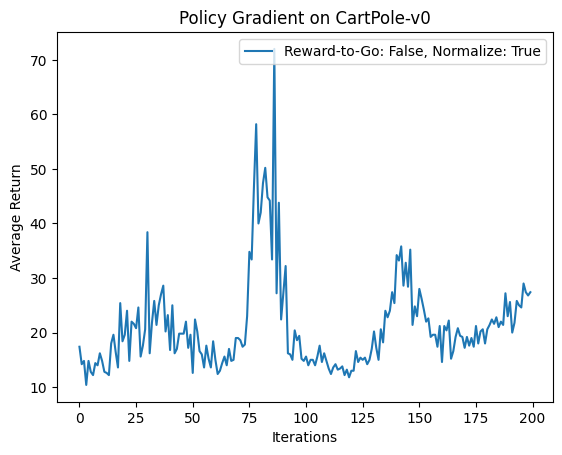

In [10]:
train_policy_gradient(env_name="CartPole-v0", reward_to_go=False, normalize_adv=True, iterations=200, batch_size=5)        

CartPole-v0Loading ...
State space : Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Iteration 10/200, Loss: 36.955020904541016
Iteration 20/200, Loss: 68.60492706298828
Iteration 30/200, Loss: 79.69509887695312
Iteration 40/200, Loss: 247.091552734375
Iteration 50/200, Loss: 1320.3851318359375
Iteration 60/200, Loss: 1016.3106689453125
Iteration 70/200, Loss: 3399.400390625
Iteration 80/200, Loss: 1618.814697265625
Iteration 90/200, Loss: 1030.6741943359375
Iteration 100/200, Loss: 1047.283447265625
Iteration 110/200, Loss: 3513.805908203125
Iteration 120/200, Loss: 4447.38427734375
Iteration 130/200, Loss: 5126.50927734375
Iteration 140/200, Loss: 4614.94384765625
Iteration 150/200, Loss: 37.1951904296875
Iteration 160/200, Loss: 24.85915756225586
Iteration 170/200, Loss: 31.257740020751953
Iteration 180/200, Loss: 20.164073944091797
Iteration 190/200, Loss: 32.48220

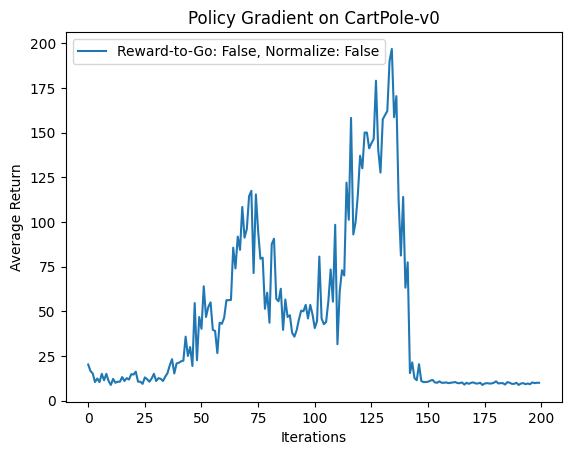

In [11]:
train_policy_gradient(env_name="CartPole-v0", reward_to_go=False, normalize_adv=False, iterations=200, batch_size=5)        

CartPole-v0Loading ...
State space : Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Iteration 10/200, Loss: 306.42376708984375
Iteration 20/200, Loss: 1485.759521484375
Iteration 30/200, Loss: 4548.71044921875
Iteration 40/200, Loss: 2853.471923828125
Iteration 50/200, Loss: 4007.948486328125
Iteration 60/200, Loss: 3597.62548828125
Iteration 70/200, Loss: 5172.09228515625
Iteration 80/200, Loss: 4604.06005859375
Iteration 90/200, Loss: 4975.29150390625
Iteration 100/200, Loss: 4856.0302734375
Iteration 110/200, Loss: 1734.4381103515625
Iteration 120/200, Loss: 4603.36669921875
Iteration 130/200, Loss: 4857.51220703125
Iteration 140/200, Loss: 4615.798828125
Iteration 150/200, Loss: 1790.24609375
Iteration 160/200, Loss: 2659.203125
Iteration 170/200, Loss: 4094.766845703125
Iteration 180/200, Loss: 3976.900390625
Iteration 190/200, Loss: 3509.63232421875
Iteration 20

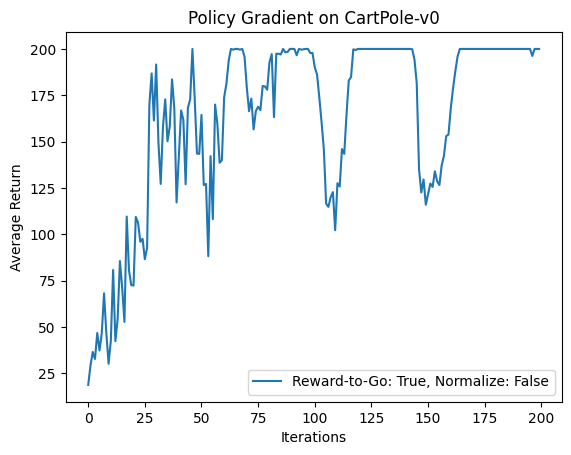

In [12]:
train_policy_gradient(env_name="CartPole-v0", reward_to_go=True, normalize_adv=False, iterations=200, batch_size=5)        

In [2]:
def train_with_batch_sizes(env_name, reward_to_go, normalize_adv, iterations, batch_sizes, gamma, lr):
    env = gym.make(env_name)
    if env is None:
        raise ValueError(f"Environment {env_name} could not be loaded.")
    print(f"Environment {env_name} loaded successfully.")
    print(f"State space: {env.observation_space}")
    print(f"Action space: {env.action_space}")

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    results = {}

    for batch_size in batch_sizes:
        print(f"\nTraining with batch size: {batch_size}")
        policy = PolicyNetwork(state_dim, action_dim)
        optimizer = optim.Adam(policy.parameters(), lr=lr)
        avg_returns = []

        for i in range(iterations):
            trajectories = []
            total_return = 0

            for _ in range(batch_size):
                states, actions, rewards, log_probs = [], [], [], []
                state = env.reset()
                done = False

                while not done:
                    action_probs = policy(state).detach().numpy()
                    action = np.random.choice(len(action_probs), p=action_probs)
                    next_state, reward, done, _ = env.step(action)

                    log_prob = torch.log(policy(state)[action])
                    states.append(state)
                    actions.append(action)
                    rewards.append(reward)
                    log_probs.append(log_prob)
                    state = next_state

                returns = calculate_returns(rewards, gamma, reward_to_go)
                if normalize_adv:
                    returns = normalize_advantages(returns)

                trajectories.append((log_probs, returns))
                total_return += sum(rewards)

            avg_returns.append(total_return / batch_size)

            loss = 0
            for log_probs, returns in trajectories:
                for log_prob, G in zip(log_probs, returns):
                    loss += -log_prob * G
            loss /= batch_size
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10 == 0:
                print(f"Iteration {i + 1}/{iterations}, Average Return: {avg_returns[-1]}")

        results[batch_size] = avg_returns

    env.close()

    # Plot learning curves for each batch size
    plt.figure(figsize=(10, 6))
    for batch_size, avg_returns in results.items():
        plt.plot(avg_returns, label=f"Batch Size: {batch_size}")
    plt.xlabel("Iterations")
    plt.ylabel("Average Return")
    plt.title(f"Policy Gradient on {env_name}")
    plt.legend()
    plt.show()


# Run training with different batch sizes
env_name = "CartPole-v0"
reward_to_go = True
normalize_adv = True
iterations = 200
batch_sizes = [10, 50, 100]  # Different batch sizes to test
gamma = 0.99
lr = 0.01

# train_with_batch_sizes(env_name, reward_to_go, normalize_adv, iterations, batch_sizes, gamma, lr)


In [6]:
!pip install stable-baselines3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
!apt-get update
!apt-get install -y build-essential swig


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]                           
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]                                
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]                             
Get:7 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [61.9 kB]                 
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,200 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,639 kB]                     
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]     
Get:11 http://security.ub

In [9]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 7.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.5 MB/s eta 0:00:0000:01
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2349113 sha256=ecc6cd20b2e4c606c3a265d7ce7fa6150128a6c78acf7f016210e6b63f9ce0ee
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [10]:
lunarlander_env = load_environment("LunarLander-v2")

LunarLander-v2Loading ...
State space : Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Discrete(4)


/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3121: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3121: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [11]:
random_agent(lunarlander_env)

Episode 1 : Total reward = -63.70938608939319 
Episode 2 : Total reward = -250.16884715383802 
Episode 3 : Total reward = -303.8940816769597 
Episode 4 : Total reward = -106.82249485542789 
Episode 5 : Total reward = -94.59371262339123 


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


LunarLander-v2Loading ...
State space : Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Discrete(4)


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Iteration 10/200, Loss: 0.13468703627586365, Avg_return: -133.3453831260084
Iteration 20/200, Loss: -14.015914916992188, Avg_return: -449.1533309942366
Iteration 30/200, Loss: 2.5983564853668213, Avg_return: -118.03123109215717
Iteration 40/200, Loss: -2.535939931869507, Avg_return: -41.56546917412512
Iteration 50/200, Loss: 12.018133163452148, Avg_return: -103.57280329539671
Iteration 60/200, Loss: 10.694578170776367, Avg_return: -69.65169730065827
Iteration 70/200, Loss: -1.9401031732559204, Avg_return: 16.828458045313305
Iteration 80/200, Loss: -23.334991455078125, Avg_return: 5.103692412556697
Iteration 90/200, Loss: 7.3858747482299805, Avg_return: -38.80644389046999
Iteration 100/200, Loss: 1.8504447937011719, Avg_return: 4.802051295194593
Iteration 110/200, Loss: 9.640649795532227, Avg_return: -23.031176579950216
Iteration 120/200, Loss: -17.174537658691406, Avg_return: 25.726702737048203
Iteration 130/200, Loss: 88.79682922363281, Avg_return: 96.15580495609487
Iteration 140/200,

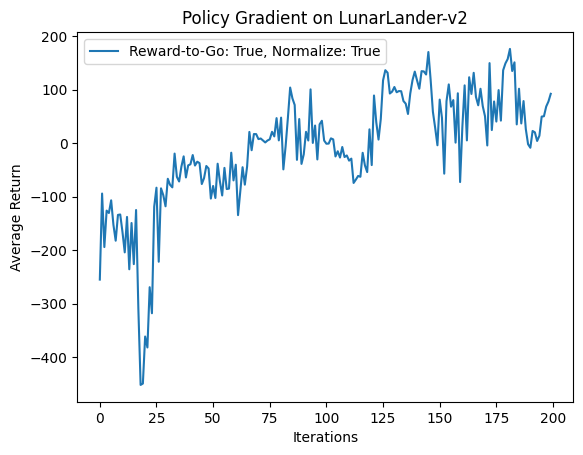

In [12]:
train_policy_gradient(env_name="LunarLander-v2", reward_to_go=True, normalize_adv=True, iterations=200, batch_size=5)        

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


LunarLander-v2Loading ...
State space : Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Discrete(4)
Iteration 10/200, Loss: -1.7375292372889817e-05, Avg_return: -121.9234174951647
Iteration 20/200, Loss: -0.00011610335059231147, Avg_return: -232.6534333150076
Iteration 30/200, Loss: 3.406471660127863e-05, Avg_return: -148.32986805038735
Iteration 40/200, Loss: 0.00022607615392189473, Avg_return: -208.2183591241972
Iteration 50/200, Loss: -0.00019642594270408154, Avg_return: -517.4966453619447
Iteration 60/200, Loss: 0.0001354883861495182, Avg_return: -220.0824191363409
Iteration 70/200, Loss: 2.7868421966559254e-05, Avg_return: -110.82312811156669
Iteration 80/200, Loss: 3.171791468048468e-05, Avg_return: -85.66581441306609
Iteration 90/200, Loss: 1.3461993148666807e-05, Avg_return: -116.31287897593401
Iteration 100/200, Loss: -0.00010409457

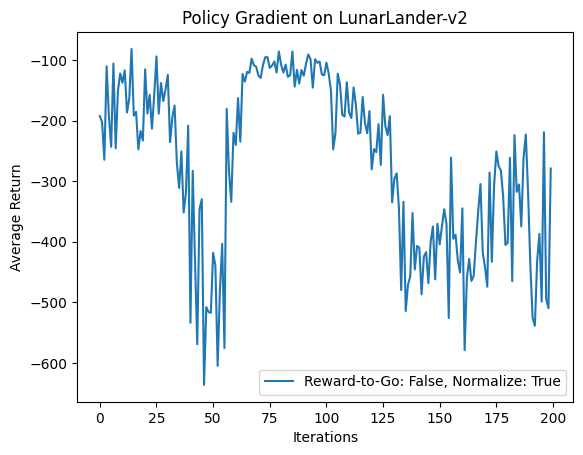

In [13]:
train_policy_gradient(env_name="LunarLander-v2", reward_to_go=False, normalize_adv=True, iterations=200, batch_size=5)        

LunarLander-v2Loading ...
State space : Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Discrete(4)
Iteration 10/200, Loss: -17031.474609375, Avg_return: -298.7630763748713
Iteration 20/200, Loss: -8271.236328125, Avg_return: -117.1770959323558
Iteration 30/200, Loss: -12133.5771484375, Avg_return: -172.68536168868437
Iteration 40/200, Loss: -10706.259765625, Avg_return: -142.96126815235166
Iteration 50/200, Loss: -6555.58056640625, Avg_return: -83.85043348409472
Iteration 60/200, Loss: -5237.07666015625, Avg_return: -66.19146253004405
Iteration 70/200, Loss: -4249.58251953125, Avg_return: -48.440194168939605
Iteration 80/200, Loss: -3485.42431640625, Avg_return: -26.672833966557484
Iteration 90/200, Loss: -4435.6513671875, Avg_return: -32.835912335006164
Iteration 100/200, Loss: -4020.007080078125, Avg_return: -24.382822534345088
Iteration 

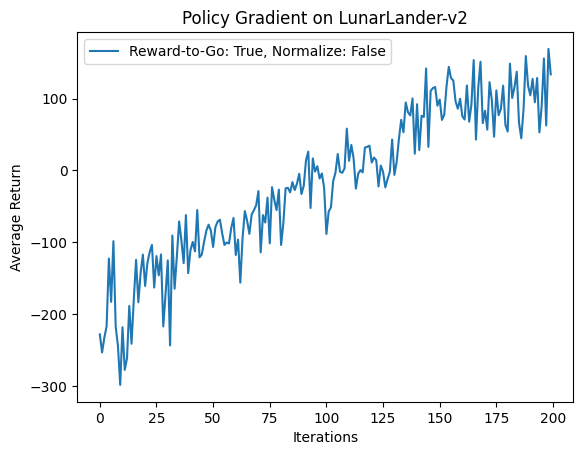

In [14]:
train_policy_gradient(env_name="LunarLander-v2", reward_to_go=True, normalize_adv=False, iterations=200, batch_size=5)        

LunarLander-v2Loading ...
State space : Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Discrete(4)
Iteration 10/200, Loss: -8124.12109375, Avg_return: -140.5065089363255
Iteration 20/200, Loss: -22216.11328125, Avg_return: -408.78315871650307
Iteration 30/200, Loss: -6324.0439453125, Avg_return: -130.0256321387683
Iteration 40/200, Loss: -4545.77099609375, Avg_return: -119.10197316326864
Iteration 50/200, Loss: -3619.40185546875, Avg_return: -137.79856178870202
Iteration 60/200, Loss: -2584.30224609375, Avg_return: -140.21451341867186
Iteration 70/200, Loss: -1780.7158203125, Avg_return: -88.13682015492884
Iteration 80/200, Loss: -2154.71728515625, Avg_return: -103.49728612555285
Iteration 90/200, Loss: -1827.192626953125, Avg_return: -118.83032212038465
Iteration 100/200, Loss: -808.2320556640625, Avg_return: -134.01101820070812
Iteration 

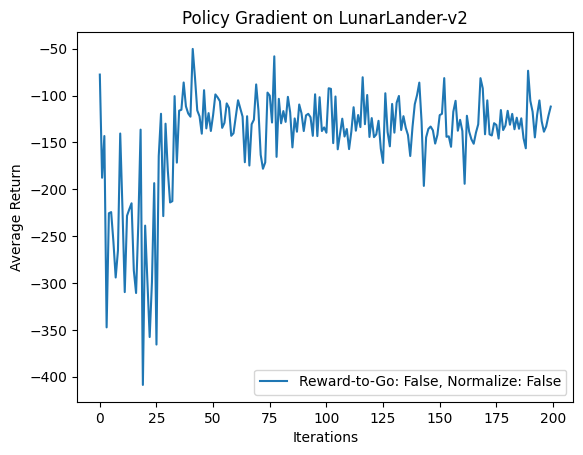

In [15]:
train_policy_gradient(env_name="LunarLander-v2", reward_to_go=False, normalize_adv=False, iterations=200, batch_size=5)        

In [ ]:
train_with_batch_sizes(env_name = "LunarLander-v2", reward_to_go = True, normalize_adv = True, iterations = 200, batch_sizes = [10, 50, 100], gamma = 0.99, lr = .01)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Environment LunarLander-v2 loaded successfully.
State space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Discrete(4)

Training with batch size: 10


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Iteration 10/200, Average Return: -148.62724000350727
Iteration 20/200, Average Return: -118.75674371911968
Iteration 30/200, Average Return: -55.82548082521229
Iteration 40/200, Average Return: -82.08299765452907
Iteration 50/200, Average Return: -126.9726359676127
Iteration 60/200, Average Return: 16.88398685065031
Iteration 70/200, Average Return: 123.88485207344786
Iteration 80/200, Average Return: 150.48097536994777
Iteration 90/200, Average Return: 179.58435296027625
Iteration 100/200, Average Return: 179.2610820334014
Iteration 110/200, Average Return: 52.68874398717414
Iteration 120/200, Average Return: 223.34440493246453
Iteration 130/200, Average Return: 116.05413248489887
Iteration 140/200, Average Return: 117.70294686245973
Iteration 150/200, Average Return: -3.9772468725293777
Iteration 160/200, Average Return: 189.790855807766
Iteration 170/200, Average Return: 44.19842010338826
Iteration 180/200, Average Return: 147.02154575360302
Iteration 190/200, Average Return: 224.4